In [1]:
include("../code/plotting_utilities.jl")
include("../code/ode_helper.jl")
include("../code/learn_polynomial_with_side_info.jl")
include("../code/vectorfield_helper.jl")

using Dates
using SumOfSquares
using DynamicPolynomials
using MosekTools
using Plots
using Random
using PyPlot
using JSON
using ProgressBars
PyPlot.rc("font", family="sans-serif", size=20)
PyPlot.rc("figure", autolayout=true)

Loaded diff equations


In [2]:
function get_vf_for_parameters(params)
    a1, b1, a2, b2, c1, c2 = params
    f(u1, u2) =    [-a1 * u1 + b1*(c1-u1)*u2
                    -a2 * u2 + b2*(c2-u2)*u1]
    return f
end

get_vf_for_parameters (generic function with 1 method)

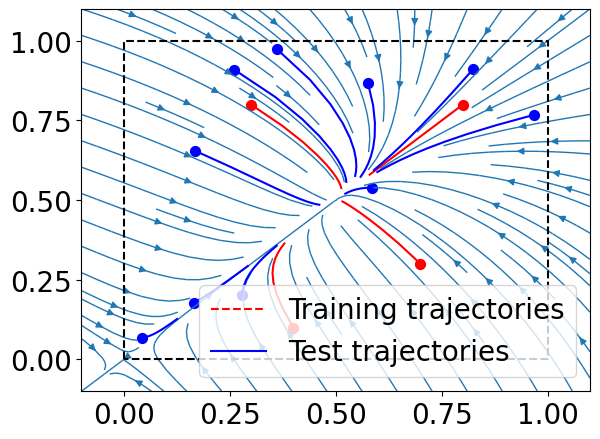

PyObject <matplotlib.legend.Legend object at 0x7f132d83af10>

In [3]:
gr(size=(600,400))
box = ((-1, 1, .1), (-1, 1, .1))
ode_p = [.05 .1 .05 .1 1. 1.]
ff = get_vf_for_parameters(ode_p)
Tf = 20.0 # T final
plot_vectorfield(ff, (-0.1, 1.1, 50), (-0.1, 1.1, 50))

training_initial_conditions = [ [.7, .3], [.4, .1], [.8, .8], [.3, .8]]
Random.seed!(0)
test_initial_conditions = [rand(2) for _ in 1:10]
#initial_conditions = [rand(2) for _ in 1:10]
for x0 in training_initial_conditions[1:end]
    sol = solve_ode(ff, x0, tspan = (0., Tf), verbose=false)
    PyPlot.plot(sol..., color=:red)
    PyPlot.scatter(x0[1], x0[2], color=:red, s=50)
end

for x0 in test_initial_conditions[1:end]
    sol = solve_ode(ff, x0, tspan = (0., Tf), verbose=false)
    PyPlot.plot(sol..., color=:blue)
    PyPlot.scatter(x0[1], x0[2], color=:blue, s=50)
end


PyPlot.plot([], [], color=:red, ls="--", label="Training trajectories")
PyPlot.plot([], [], color=:blue, label="Test trajectories")
plot_box()
PyPlot.legend()


In [4]:
box_invariance(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p
   
    int_y = @set x2 >= 0 && 1 - x2 >= 0
    int_x = @set x1 >= 0 && 1 - x1 >= 0

    @constraint(model, subs(p1, x1=>0) >= 0, domain=int_x )
    @constraint(model, -subs(p1, x1=>1) >= 0, domain=int_y )
    @constraint(model, subs(p2, x2=>0) >= 0, domain=int_x )
    @constraint(model, -subs(p2, x2=>1) >= 0, domain=int_y )
end


monotonicity(model, p, x) = begin
    x1, x2 = x
    p1, p2 = p

    Box = @set 1 - x1 >=  0 && x1 >= 0 && 1 - x2 >= 0 && x2 >= 0
    @constraint(model, differentiate(p1, x2) >= 0, domain=Box)
    @constraint(model, differentiate(p2, x1) >= 0, domain=Box)
end

equilibrium_points(model, p, x) = begin
    @constraint model p[1](0, 0) == 0
    @constraint model p[2](0, 0) == 0
end

equilibrium_points (generic function with 1 method)

In [5]:
r = train_and_test_model(2, .01, 1, 10, Dict(),training_initial_conditions,
                                test_initial_conditions, Tf, box; verbose=false)
r["obj_value"] / r["training"]

2.6392042599623693

In [6]:
side_info = [
    Dict(),
    Dict("equilibrium_points" => equilibrium_points),
    Dict("equilibrium_points" => equilibrium_points,
                "box_invariance" => box_invariance),
    Dict("equilibrium_points" => equilibrium_points,
        "box_invariance" => box_invariance,
        "monotonicity" => monotonicity)
]
    
deg = (2, 3, 4, 5, 6)
noise_level = (0, 1e-3, 1e-2, 1e-1, )
num_trajectories = (1, 2, 3, 4)
num_samples = (10, 20, 40)

results = [train_and_test_model(args...,
                                training_initial_conditions,
                                test_initial_conditions, Tf, box; verbose=false)
                for args in tqdm(Iterators.product(deg, noise_level, num_trajectories, num_samples, side_info))];

0.0%┣                                             ┫ 0/960 [00:00<00:-48, -0s/it]
0.1%┣                                          ┫ 1/960 [00:01<Inf:Inf, InfGs/it]
0.2%┣                                               ┫ 2/960 [00:01<17:43, 1s/it]
0.3%┣▏                                              ┫ 3/960 [00:01<11:18, 1it/s]
0.4%┣▏                                              ┫ 4/960 [00:02<09:16, 2it/s]
0.5%┣▎                                              ┫ 5/960 [00:02<08:35, 2it/s]
0.6%┣▎                                              ┫ 6/960 [00:02<07:52, 2it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Abortin

1.4%┣▋                                             ┫ 13/960 [00:03<04:24, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

2.1%┣█                                             ┫ 20/960 [00:04<03:16, 5it/s]
2.2%┣█                                             ┫ 21/960 [00:04<03:24, 5it/s]
2.3%┣█                                             ┫ 22/960 [00:05<03:28, 5it/s]
2.4%┣█                                             ┫ 23/960 [00:05<03:30, 4it/s]
2.5%┣█▏                                            ┫ 24/960 [00:05<03:35, 4it/s]
2.6%┣█▏                                            ┫ 25/960 [00:06<03:43, 4it/s]
2.7%┣█▎                                            ┫ 26/960 [00:06<03:44, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Abortin

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
3.6%┣█▊                                            ┫ 35/960 [00:07<03:22, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
3.8%┣█▊                                            ┫ 36/960 [00:08<03:21, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
5.7%┣██▋                                           ┫ 55/960 [00:12<03:15, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
5.8%┣██▊                                           ┫ 56/960 [00:12<03:16, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
7.0%┣███▏                                          ┫ 67/960 [00:15<03:21, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
7.1%┣███▎                                          ┫ 68/960 [00:15<03:22, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

8.1%┣███▊                                          ┫ 78/960 [00:18<03:26, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

9.3%┣████▎                                         ┫ 89/960 [00:20<03:20, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
11.2%┣█████                                       ┫ 108/960 [00:23<03:03, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
12.1%┣█████▎                                      ┫ 116/960 [00:24<02:57, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

13.3%┣█████▉                                      ┫ 128/960 [00:27<02:57, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
13.4%┣██████                                      ┫ 129/960 [00:27<02:57, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
14.3%┣██████▎                                     ┫ 137/960 [00:29<02:56, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
16.0%┣███████                                     ┫ 154/960 [00:34<03:01, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

17.5%┣███████▊                                    ┫ 168/960 [00:37<02:57, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
17.6%┣███████▊                                    ┫ 169/960 [00:38<02:57, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

19.8%┣████████▊                                   ┫ 190/960 [00:41<02:47, 5it/s]
19.9%┣████████▊                                   ┫ 191/960 [00:41<02:47, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
20.7%┣█████████▏                                  ┫ 199/960 [00:42<02:42, 5it/s]
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
22.4%┣█████████▉                                  ┫ 215/960 [00:46<02:42, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
22.5%┣██████████                                  ┫ 216/960 [00:47<02:42, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
24.0%┣██████████▌                                 ┫ 230/960 [00:51<02:42, 5it/s]
24.1%┣██████████▋                                 ┫ 231/960 [00:51<02:42, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
24.8%┣███████████                                 ┫ 238/960 [00:53<02:41, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
26.0%┣███████████▌                                ┫ 250/960 [00:57<02:43, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

26.8%┣███████████▉                                ┫ 257/960 [00:58<02:39, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

28.1%┣████████████▍                               ┫ 270/960 [01:01<02:36, 4it/s]
28.2%┣████████████▍                               ┫ 271/960 [01:01<02:35, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
28.3%┣████████████▌                               ┫ 272/960 [01:01<02:35, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
29.2%┣████████████▉                               ┫ 280/960 [01:02<02:31, 4it/s]
29.3%┣████████████▉                               ┫ 281/960 [01:02<02:31, 4it/s]
29.4%┣█████████████                               ┫ 282/960 [01:03<02:31, 4it/s]
29.5%┣█████████████                               ┫ 283/960 [01:03<02:31, 4it/s]
29.6%┣█████████████                               ┫ 284/960 [01:03<02:31, 4it/s]
29.7%┣█████████████                               ┫ 285/960 [01:04<02:32, 4it/s]
29.8%┣█████████████                               ┫ 286/960 [01:04<02:32, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Abortin

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
30.5%┣█████████████▍                              ┫ 293/960 [01:05<02:29, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
31.2%┣█████████████▊                              ┫ 300/960 [01:06<02:26, 5it/s]
31.4%┣█████████████▉                              ┫ 301/960 [01:06<02:26, 5it/s]
31.5%┣█████████████▉                              ┫ 302/960 [01:07<02:26, 5it/s]
31.6%┣█████████████▉                              ┫ 303/960 [01:07<02:26, 4it/s]
31.7%┣██████████████                              ┫ 304/960 [01:08<02:26, 4it/s]
31.8%┣██████████████                              ┫ 305/960 [01:08<02:26, 4it/s]
31.9%┣██████████████                              ┫ 306/960 [01:08<02:27, 4it/s]
32.0%┣██████████████                              ┫ 307/960 [01:09<02:26, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBa

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
33.0%┣██████████████▌                             ┫ 317/960 [01:11<02:25, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
33

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
34.4%┣███████████████▏                            ┫ 330/960 [01:14<02:22, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
36.4%┣████████████████                            ┫ 349/960 [01:17<02:15, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
37.1%┣████████████████▎                           ┫ 356/960 [01:18<02:12, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

38.4%┣█████████████████                           ┫ 369/960 [01:21<02:10, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
38.5%┣█████████████████                           ┫ 370/960 [01:21<02:10, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
38.6%┣█████████████████                           ┫ 371/960 [01:22<02:10, 5it/s]
38.8%┣█████████████████                           ┫ 372/960 [01:22<02:10, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instabilit

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
39.5%┣█████████████████▍                          ┫ 379/960 [01:23<02:08, 5it/s]
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
41.7%┣██████████████████▍                         ┫ 400/960 [01:30<02:06, 4it/s]
41.8%┣██████████████████▍                         ┫ 401/960 [01:30<02:06, 4it/s]
41.9%┣██████████████████▍                         ┫ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
43.0%┣███████████████████                         ┫ 413/960 [01:32<02:02, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

43.9%┣███████████████████▎                        ┫ 421/960 [01:33<01:59, 5it/s]
44.0%┣███████████████████▍                        ┫ 422/960 [01:33<01:59, 5it/s]
44.1%┣███████████████████▍                        ┫ 423/960 [01:33<01:59, 5it/s]
44.2%┣███████████████████▍                        ┫ 424/960 [01:34<01:59, 5it/s]
44.3%┣███████████████████▌                        ┫ 425/960 [01:34<01:59, 5it/s]
44.4%┣███████████████████▌                        ┫ 426/960 [01:34<01:59, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interfa

45.4%┣████████████████████                        ┫ 436/960 [01:36<01:56, 5it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
47.1%┣████████████████████▊                       ┫ 452/960 [01:40<01:53, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
47.2%┣████████████████████▊                       ┫ 453/960 [01:41<01:53, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

48.0%┣█████████████████████▏                      ┫ 461/960 [01:42<01:51, 5it/s]
48.1%┣█████████████████████▏                      ┫ 462/960 [01:42<01:51, 5it/s]
48.2%┣█████████████████████▏                      ┫ 463/960 [01:43<01:51, 4it/s]
48.3%┣█████████████████████▎                      ┫ 464/960 [01:43<01:51, 4it/s]
48.4%┣█████████████████████▎                      ┫ 465/960 [01:44<01:51, 4it/s]
48.5%┣█████████████████████▍                      ┫ 466/960 [01:44<01:50, 4it/s]
48.6%┣█████████████████████▍                      ┫ 467/960 [01:44<01:50, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
48.8%┣█████████████████████▌            

49.6%┣█████████████████████▉                      ┫ 476/960 [01:47<01:49, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

51.5%┣██████████████████████▋                     ┫ 494/960 [02:02<01:55, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

52.8%┣███████████████████████▎                    ┫ 507/960 [02:05<01:52, 4it/s]
52.9%┣███████████████████████▎                    ┫ 508/960 [02:05<01:52, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
53.0%┣███████████████████████▎                    ┫ 509/960 [02:06<01:51, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
53.1%┣███████████████████████▍                    ┫ 510/960 [02:06<01:51, 4it/s]
53.2%┣███████████████████████▍                    ┫ 511/960 [02:06<01:51, 4it/s]
53.3%┣███████████████████████▌                    ┫ 512/960 [02:07<01:5

54.3%┣███████████████████████▉                    ┫ 521/960 [02:08<01:48, 4it/s]
54.4%┣████████████████████████                    ┫ 522/960 [02:09<01:48, 4it/s]
54.5%┣████████████████████████                    ┫ 523/960 [02:09<01:48, 4it/s]
54.6%┣████████████████████████                    ┫ 524/960 [02:09<01:48, 4it/s]
54.7%┣████████████████████████                    ┫ 525/960 [02:10<01:48, 4it/s]
54.8%┣████████████████████████                    ┫ 526/960 [02:10<01:48, 4it/s]
54.9%┣████████████████████████▏                   ┫ 527/960 [02:11<01:48, 4it/s]
55.0%┣████████████████████████▏                   ┫ 528/960 [02:11<01:47, 4it/s]
55.1%┣████████████████████████▎                   ┫ 529/960 [02:11<01:47, 4it/s]
55.2%┣████████████████████████▎                   ┫ 530/960 [02:12<01:47, 4it/s]
55.3%┣████████████████████████▍                   ┫ 531/960 [02:12<01:47, 4it/s]
55.4%┣████████████████████████▍                   ┫ 532/960 [02:12<01:47, 4it/s]
55.5%┣██████████████████████

59.4%┣██████████████████████████▏                 ┫ 570/960 [02:26<01:40, 4it/s]
59.5%┣██████████████████████████▏                 ┫ 571/960 [02:26<01:40, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLB

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

63.5%┣████████████████████████████                ┫ 610/960 [02:37<01:30, 4it/s]
63.6%┣████████████████████████████                ┫ 611/960 [02:37<01:30, 4it/s]
63.7%┣████████████████████████████                ┫ 612/960 [02:37<01:30, 4it/s]
63.9%┣████████████████████████████                ┫ 613/960 [02:37<01:29, 4it/s]
64.0%┣████████████████████████████▏               ┫ 614/960 [02:38<01:29, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
64.1%┣████████████████████████████▏               ┫ 615/960 [02:38<01:29, 4it/s]
64.2%┣████████████████████████████▎               ┫ 616/960 [02:39<01:29, 4it/s]
64.3%┣████████████████████████████▎               ┫ 617/960 [02:39<01:29, 4it/s]
64.4%┣████████████████████████████▎               ┫ 618/960 [02:39<01:28, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning

┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/

68.6%┣██████████████████████████████▏             ┫ 659/960 [02:52<01:19, 4it/s]
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ Warning: Instability detected. Aborting
└ @ SciMLBase /home/user/.julia/packages/SciMLBase/x3z0g/src/integrator_interface.jl:351
┌ 

70.9%┣███████████████████████████████▏            ┫ 681/960 [02:58<01:13, 4it/s]
71.0%┣███████████████████████████████▎            ┫ 682/960 [02:58<01:13, 4it/s]
71.1%┣███████████████████████████████▎            ┫ 683/960 [02:59<01:13, 4it/s]
71.2%┣███████████████████████████████▍            ┫ 684/960 [02:59<01:12, 4it/s]
71.4%┣███████████████████████████████▍            ┫ 685/960 [03:00<01:12, 4it/s]
71.5%┣███████████████████████████████▍            ┫ 686/960 [03:00<01:12, 4it/s]
71.6%┣███████████████████████████████▌            ┫ 687/960 [03:00<01:12, 4it/s]
71.7%┣███████████████████████████████▌            ┫ 688/960 [03:01<01:11, 4it/s]
71.8%┣███████████████████████████████▋            ┫ 689/960 [03:01<01:11, 4it/s]
71.9%┣███████████████████████████████▋            ┫ 690/960 [03:01<01:11, 4it/s]
72.0%┣███████████████████████████████▊            ┫ 691/960 [03:02<01:11, 4it/s]
72.1%┣███████████████████████████████▊            ┫ 692/960 [03:02<01:11, 4it/s]
72.2%┣██████████████████████

77.2%┣██████████████████████████████████          ┫ 741/960 [03:20<00:59, 4it/s]
77.3%┣██████████████████████████████████          ┫ 742/960 [03:20<00:59, 4it/s]
77.4%┣██████████████████████████████████          ┫ 743/960 [03:21<00:59, 4it/s]
77.5%┣██████████████████████████████████          ┫ 744/960 [03:21<00:58, 4it/s]
77.6%┣██████████████████████████████████▏         ┫ 745/960 [03:21<00:58, 4it/s]
77.7%┣██████████████████████████████████▏         ┫ 746/960 [03:22<00:58, 4it/s]
77.8%┣██████████████████████████████████▎         ┫ 747/960 [03:22<00:58, 4it/s]
77.9%┣██████████████████████████████████▎         ┫ 748/960 [03:22<00:57, 4it/s]
78.0%┣██████████████████████████████████▎         ┫ 749/960 [03:23<00:57, 4it/s]
78.1%┣██████████████████████████████████▍         ┫ 750/960 [03:23<00:57, 4it/s]
78.2%┣██████████████████████████████████▍         ┫ 751/960 [03:23<00:57, 4it/s]
78.3%┣██████████████████████████████████▌         ┫ 752/960 [03:24<00:56, 4it/s]
78.4%┣██████████████████████

In [7]:
date_now = Dates.format(now(),"yyyy-mm-dd--HH-MM")
open("../data/disease-table/results-$(date_now).json","w") do f 
    JSON.print(f, results, 4)
end